In [ ]:
#Name: Roshan Kumar Sahu
#Roll: 121CS0228

In [59]:
# Import required packages
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
import os
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns
warnings.filterwarnings("ignore")

In [60]:
# split a univariate time series into patterns
def get_Patterns(TSeries, n_inputs,h):
    X,y,z = pd.DataFrame(np.zeros((len(TSeries)-n_inputs-h+1,n_inputs))), pd.DataFrame(), pd.DataFrame()
    for i in range(len(TSeries)):
        # find the end of this pattern
        end_ix = i + n_inputs + h - 1
        # check if we are beyond the time series
        if end_ix > len(TSeries)-1:
            break
        # gather input and output parts of the pattern
        for j in range(n_inputs):
            X.loc[i,j]=TSeries.iloc[i+j,0]
        i=i+n_inputs
        #y=y.append(TSeries.iloc[end_ix], ignore_index = True)
        y=pd.concat([y, TSeries.iloc[end_ix]], ignore_index=True)
        sinX=pd.DataFrame(np.sin(X))
        cosX=pd.DataFrame(np.cos(X))
        squareX=pd.DataFrame(np.power(X,2))
        #X1=pd.concat([X,sinX,cosX,squareX], axis=1)
        X1=X
    return pd.DataFrame(X),pd.DataFrame(y)

In [61]:
# originalData should be a Column Vectored DataFrame
def minmaxNorm(originalData, lenTrainValidation):
    max2norm=max(originalData.iloc[0:lenTrainValidation,0])
    min2norm=min(originalData.iloc[0:lenTrainValidation,0])
    lenOriginal=len(originalData)
    normalizedData=np.zeros(lenOriginal)   
    normalizedData = []
    for i in range (lenOriginal):
        normalizedData.append((originalData.iloc[i]-min2norm)/(max2norm-min2norm))    
    return pd.DataFrame(normalizedData)

In [62]:
# originalData and forecastedData should be Column Vectored DataFrames
def minmaxDeNorm( originalData, forecastedData, lenTrainValidation):
    # Maximum Value
    max2norm=max(originalData.iloc[0:lenTrainValidation,0])
    # Minimum Value
    min2norm=min(originalData.iloc[0:lenTrainValidation,0])
    lenOriginal=len(originalData)
    denormalizedData=[]   
    #De-Normalize using Min-Max Normalization
    for i in range (lenOriginal):
        denormalizedData.append((forecastedData.iloc[i]*(max2norm-min2norm))+min2norm)  
    return pd.DataFrame(denormalizedData)

In [63]:
# Timeseries_Data and forecasted_value should be Column Vectored DataFrames
def findRMSE( Timeseries_Data, forecasted_value,lenTrainValidation):
    l=Timeseries_Data.shape[0]
    lenTest=l-lenTrainValidation
    # RMSE on Train & Validation Set
    trainRMSE=0;
    for i in range (lenTrainValidation):
        trainRMSE=trainRMSE+np.power((forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]),2) 
    trainRMSE=np.sqrt(trainRMSE/lenTrainValidation)
    # RMSE on Test Set
    testRMSE=0;
    for i in range (lenTrainValidation,l,1):
        testRMSE=testRMSE+np.power((forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]),2)
    testRMSE=np.sqrt(testRMSE/lenTest)
    return trainRMSE, testRMSE 

In [64]:
# Timeseries_Data and forecasted_value should be Column Vectored DataFrames
def findMAE(Timeseries_Data, forecasted_value,lenTrainValidation):
    l=Timeseries_Data.shape[0]
    lenTest=l-lenTrainValidation
    # MAE on Train & Validation Set
    trainMAE=0;
    for i in range (lenTrainValidation):
        trainMAE=trainMAE+np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0]) 
    trainMAE=(trainMAE/(lenTrainValidation));
    # MAE on Test Set
    testMAE=0;
    for i in range (lenTrainValidation,l,1):
        testMAE=testMAE+np.abs(forecasted_value.iloc[i,0]-Timeseries_Data.iloc[i,0])
    testMAE=(testMAE/lenTest);
    return trainMAE, testMAE

In [65]:
def Find_Fitness(x,y,lenValid,lenTest,model):
    NOP=y.shape[0]
    lenTrain=NOP-lenValid-lenTest
    xTrain=x.iloc[0:lenTrain,:]
    xValid=x.iloc[lenTrain:(lenTrain+lenValid),:]
    xTest=x.iloc[(lenTrain+lenValid):NOP,:]
    yTrain=y.iloc[0:lenTrain,0]
    yValid=y.iloc[lenTrain:(lenTrain+lenValid),0]
    yTest=y.iloc[(lenTrain+lenValid):NOP,0]
    model.fit(xTrain, yTrain)
    yhatNorm=model.predict(x).flatten().reshape(x.shape[0],1)
    return pd.DataFrame(yhatNorm)

In [66]:
#Read the Time Series Dataset
Timeseries_Data=pd.read_csv('Lynx.csv',header=None)
Timeseries_Data.describe()

,0
count,114.000000
mean,1538.017544
std,1585.843914
min,39.000000
25%,348.250000
50%,771.000000
75%,2566.750000
max,6991.000000


The Autocorrelation plot for the data is:


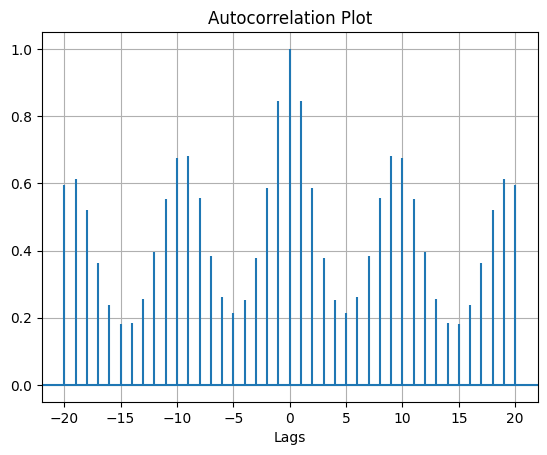

In [67]:
plt.title("Autocorrelation Plot") 
# Providing x-axis name.
plt.xlabel("Lags") 
# Plotting the Autocorrelation plot.
plt.acorr(np.array(Timeseries_Data.iloc[:,0], dtype=float), maxlags = 20) 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
plt.show() 

<Axes: ylabel='Count'>

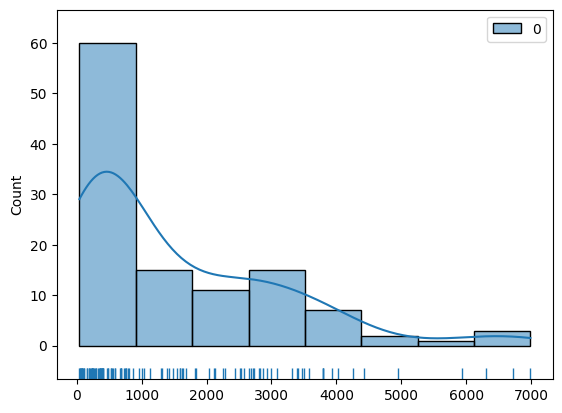

In [68]:
#4. Rug plot — sns.rugplot()
sns.rugplot(data=Timeseries_Data, height=.03, color='darkblue')
sns.histplot(data=Timeseries_Data, kde=True)

In [69]:
LagLength=10
h=1
lt=Timeseries_Data.shape[0]
lenTrain=int(round(lt*0.7))
lenValidation=int(round(lt*0.15))
lenTest=int(lt-lenTrain-lenValidation)
# NORMALIZE THE DATA
normalizedData=minmaxNorm(Timeseries_Data,lenTrain+lenValidation);
# Transform the Time Series into Patterns Using Sliding Window
X, y = get_Patterns(normalizedData, LagLength, h)
model=LinearRegression()
name='LinearRegression'
file1='./'+str(name)+"_Accuracy.xlsx"
file2='./'+str(name)+"_Forecasts.xlsx"
Forecasts=pd.DataFrame()
Accuracy=pd.DataFrame()

ynorm1=Find_Fitness(X,y,lenValidation,lenTest,model)
ynorm=pd.DataFrame(normalizedData.iloc[0:(LagLength+h-1),0])
ynorm=pd.concat([ynorm, ynorm1], ignore_index=True)
yhat=minmaxDeNorm(Timeseries_Data, ynorm, lenTrain+lenValidation)
Accuracy.loc[0,0],Accuracy.loc[0,1]=findRMSE( Timeseries_Data,yhat,lenTrain+lenValidation)
Accuracy.loc[0,2],Accuracy.loc[0,3]=findMAE( Timeseries_Data,yhat,lenTrain+lenValidation)
Forecasts=pd.concat([Forecasts, yhat.T], ignore_index=True)
Accuracy.to_excel(file1,sheet_name='Accuracy',index=False)
Forecasts.to_excel(file2,sheet_name='Forecasts',index=False)
print(Accuracy)

            0           1           2         3
0  804.186429  543.701142  530.371979  440.0537


In [70]:
#Q2
LagLength=10
h=1
lt=Timeseries_Data.shape[0]
lenTrain=int(round(lt*0.7))
lenValidation=int(round(lt*0.15))
lenTest=int(lt-lenTrain-lenValidation)
# NORMALIZE THE DATA
normalizedData=minmaxNorm(Timeseries_Data,lenTrain+lenValidation);
# Transform the Time Series into Patterns Using Sliding Window
X, y = get_Patterns(normalizedData, LagLength, h)
model=MLPRegressor()
name='MLPRegression'
file1='./'+str(name)+"_Accuracy.xlsx"
file2='./'+str(name)+"_Forecasts.xlsx"
Forecasts=pd.DataFrame()
Accuracy=pd.DataFrame()

arr=np.zeros((10,4))
ans=np.zeros((1,4))
for i in range(10):
    ynorm1=Find_Fitness(X,y,lenValidation,lenTest,model)
    ynorm=pd.DataFrame(normalizedData.iloc[0:(LagLength+h-1),0])
    ynorm=pd.concat([ynorm, ynorm1], ignore_index=True)
    yhat=minmaxDeNorm(Timeseries_Data, ynorm, lenTrain+lenValidation)
    Accuracy.loc[0,0],Accuracy.loc[0,1]=findRMSE( Timeseries_Data,yhat,lenTrain+lenValidation)
    Accuracy.loc[0,2],Accuracy.loc[0,3]=findMAE( Timeseries_Data,yhat,lenTrain+lenValidation)
    Forecasts=pd.concat([Forecasts, yhat.T], ignore_index=True)
    Accuracy.to_excel(file1,sheet_name='Accuracy',index=False)
    Forecasts.to_excel(file2,sheet_name='Forecasts',index=False)
    arr[i]=Accuracy
print(arr)
for i in range(10):
    ans[0]+=(arr[i]/10)
print("The mean is ",ans)

[[ 962.11567854  609.49333407  616.92860307  478.203292  ]
 [ 901.23774683  651.89671447  552.90277457  549.11260565]
 [ 895.93463031  578.81928827  582.10383617  485.45669102]
 [1038.82287038  646.04579912  676.12641705  538.0441936 ]
 [ 918.04636862  601.6508874   569.6168001   518.14231627]
 [1021.82142635  818.62626424  654.48906361  723.29815528]
 [ 990.4008526   773.49387026  643.10833403  660.560692  ]
 [ 986.64517568  716.83859486  624.33410619  618.45001796]
 [1062.20288992  735.08821594  675.34530266  629.80158753]
 [1025.85860902  649.8445702   696.73961158  561.7621713 ]]
The mean is  [[980.30862483 678.17975388 629.1694849  576.28317226]]


The Autocorrelation plot for the data is:


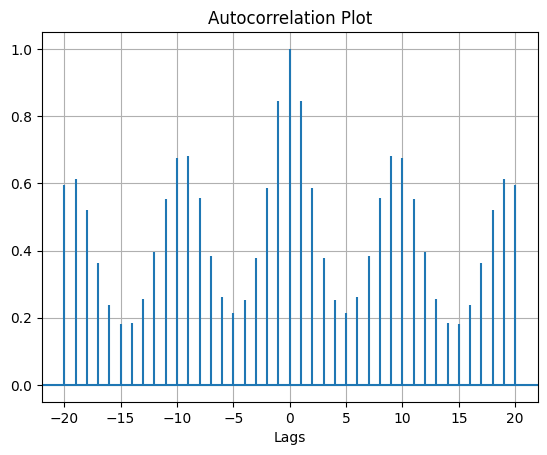

In [71]:
#Q3
plt.title("Autocorrelation Plot") 
# Providing x-axis name.
plt.xlabel("Lags") 
# Plotting the Autocorrelation plot.
plt.acorr(np.array(Timeseries_Data.iloc[:,0], dtype=float), maxlags = 20) 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
plt.show() 

In [72]:
#By observing the autocorrelation plot, it found that the cycle repeats at a period of 10.
temp=Timeseries_Data[0:len(Timeseries_Data)-len(Timeseries_Data)%10].values
temp_arr=np.zeros((10,1))
for i in range(110):
    temp_arr[i%10][0]=temp[i][0]/11
Timeseries_nocycle=np.zeros((110,1))
for i in range(110):
    Timeseries_nocycle[i][0]=temp[i][0]-temp_arr[i%10][0]
Timeseries_nocycle=pd.DataFrame(Timeseries_nocycle)
Timeseries_nocycle.head

<bound method NDFrame.head of                0
0     248.181818
1     284.727273
2     482.090909
3     649.909091
4    1150.090909
..           ...
105  2668.181818
106  1397.272727
107   480.909091
108   440.909091
109   601.818182

[110 rows x 1 columns]>

The Autocorrelation plot for the data is:


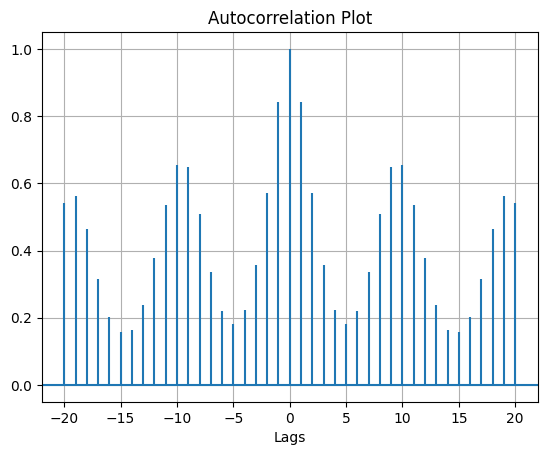

In [78]:
#Q3
plt.title("Autocorrelation Plot") 
# Providing x-axis name.
plt.xlabel("Lags") 
# Plotting the Autocorrelation plot.
plt.acorr(np.array(Timeseries_nocycle.iloc[:,0], dtype=float), maxlags = 20) 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
plt.show() 

In [73]:
LagLength=10
h=1
lt=Timeseries_nocycle.shape[0]
lenTrain=int(round(lt*0.7))
lenValidation=int(round(lt*0.15))
lenTest=int(lt-lenTrain-lenValidation)
# NORMALIZE THE DATA
normalizedData=minmaxNorm(Timeseries_nocycle,lenTrain+lenValidation);
# Transform the Time Series into Patterns Using Sliding Window
X, y = get_Patterns(normalizedData, LagLength, h)
model=LinearRegression()
name='LinearRegression'
file1='./'+str(name)+"_AccuracyQ3.xlsx"
file2='./'+str(name)+"_ForecastsQ3.xlsx"
Forecasts=pd.DataFrame()
Accuracy=pd.DataFrame()

ynorm1=Find_Fitness(X,y,lenValidation,lenTest,model)
ynorm=pd.DataFrame(normalizedData.iloc[0:(LagLength+h-1),0])
ynorm=pd.concat([ynorm, ynorm1], ignore_index=True)
yhat=minmaxDeNorm(Timeseries_nocycle, ynorm, lenTrain+lenValidation)
Accuracy.loc[0,0],Accuracy.loc[0,1]=findRMSE( Timeseries_nocycle,yhat,lenTrain+lenValidation)
Accuracy.loc[0,2],Accuracy.loc[0,3]=findMAE( Timeseries_nocycle,yhat,lenTrain+lenValidation)
Forecasts=pd.concat([Forecasts, yhat.T], ignore_index=True)
Accuracy.to_excel(file1,sheet_name='Accuracy',index=False)
Forecasts.to_excel(file2,sheet_name='Forecasts',index=False)
print(Accuracy)

            0           1           2           3
0  777.466406  756.166474  503.611602  571.452595


In [74]:
#Q4
LagLength=10
h=1
lt=Timeseries_nocycle.shape[0]
lenTrain=int(round(lt*0.7))
lenValidation=int(round(lt*0.15))
lenTest=int(lt-lenTrain-lenValidation)
# NORMALIZE THE DATA
normalizedData=minmaxNorm(Timeseries_nocycle,lenTrain+lenValidation);
# Transform the Time Series into Patterns Using Sliding Window
X, y = get_Patterns(normalizedData, LagLength, h)
model=MLPRegressor()
name='MLPRegression'
file1='./'+str(name)+"_AccuracyQ4.xlsx"
file2='./'+str(name)+"_ForecastsQ4.xlsx"
Forecasts=pd.DataFrame()
Accuracy=pd.DataFrame()

arr=np.zeros((10,4))
ans=np.zeros((1,4))
for i in range(10):
    ynorm1=Find_Fitness(X,y,lenValidation,lenTest,model)
    ynorm=pd.DataFrame(normalizedData.iloc[0:(LagLength+h-1),0])
    ynorm=pd.concat([ynorm, ynorm1], ignore_index=True)
    yhat=minmaxDeNorm(Timeseries_nocycle, ynorm, lenTrain+lenValidation)
    Accuracy.loc[0,0],Accuracy.loc[0,1]=findRMSE( Timeseries_nocycle,yhat,lenTrain+lenValidation)
    Accuracy.loc[0,2],Accuracy.loc[0,3]=findMAE( Timeseries_nocycle,yhat,lenTrain+lenValidation)
    Forecasts=pd.concat([Forecasts, yhat.T], ignore_index=True)
    Accuracy.to_excel(file1,sheet_name='Accuracy',index=False)
    Forecasts.to_excel(file2,sheet_name='Forecasts',index=False)
    arr[i]=Accuracy
print(arr)
for i in range(10):
    ans[0]+=(arr[i]/10)
print("The mean is ",ans)

[[ 981.18148698  788.16783864  648.19559309  572.24887683]
 [ 969.10686804  733.48764199  635.55995146  559.76265789]
 [1118.47985352  749.5618457   825.90409054  475.4755711 ]
 [ 959.41876534  768.27445304  642.57748237  569.33726477]
 [ 833.16022232  735.52265651  485.7676691   533.60222201]
 [ 914.22943497  732.99638505  574.37406369  532.74674565]
 [ 905.44575518  721.30040172  577.8599774   553.44477931]
 [ 920.37813268  730.47270174  590.99988976  529.0260276 ]
 [1038.94034681  858.20548565  680.817319    633.84615319]
 [1048.00551261 1043.33212097  748.59449438  831.1859039 ]]
The mean is  [[968.83463785 786.1321531  641.06505308 579.06762023]]


In [75]:
#Q5
temp1=Timeseries_Data[0:len(Timeseries_Data)].values
temp_arr1=np.zeros((10,1))
for i in range(10):
    temp_arr1[i][0]=temp1[i][0]
Timeseries_nocycle1=np.zeros((114,1))
for i in range(10):
    Timeseries_nocycle1[i][0]=temp1[i][0]
for i in range(10,114):
    Timeseries_nocycle1[i][0]=temp1[i][0]-temp_arr1[i%10][0]
Timeseries_nocycle1=pd.DataFrame(Timeseries_nocycle1)
Timeseries_nocycle1.head

<bound method NDFrame.head of           0
0     269.0
1     321.0
2     585.0
3     871.0
4    1475.0
..      ...
109 -1915.0
110   731.0
111  1269.0
112  2072.0
113  2525.0

[114 rows x 1 columns]>

In [76]:
LagLength=10
h=1
lt=Timeseries_nocycle1.shape[0]
lenTrain=int(round(lt*0.7))
lenValidation=int(round(lt*0.15))
lenTest=int(lt-lenTrain-lenValidation)
# NORMALIZE THE DATA
normalizedData=minmaxNorm(Timeseries_nocycle1,lenTrain+lenValidation);
# Transform the Time Series into Patterns Using Sliding Window
X, y = get_Patterns(normalizedData, LagLength, h)
model=LinearRegression()
name='LinearRegression'
file1='./'+str(name)+"_AccuracyQ5.xlsx"
file2='./'+str(name)+"_ForecastsQ5.xlsx"
Forecasts=pd.DataFrame()
Accuracy=pd.DataFrame()

ynorm1=Find_Fitness(X,y,lenValidation,lenTest,model)
ynorm=pd.DataFrame(normalizedData.iloc[0:(LagLength+h-1),0])
ynorm=pd.concat([ynorm, ynorm1], ignore_index=True)
yhat=minmaxDeNorm(Timeseries_nocycle1, ynorm, lenTrain+lenValidation)
Accuracy.loc[0,0],Accuracy.loc[0,1]=findRMSE( Timeseries_nocycle1,yhat,lenTrain+lenValidation)
Accuracy.loc[0,2],Accuracy.loc[0,3]=findMAE( Timeseries_nocycle1,yhat,lenTrain+lenValidation)
Forecasts=pd.concat([Forecasts, yhat.T], ignore_index=True)
Accuracy.to_excel(file1,sheet_name='Accuracy',index=False)
Forecasts.to_excel(file2,sheet_name='Forecasts',index=False)
print(Accuracy)

            0           1           2           3
0  933.939998  693.497328  690.308493  551.960481


In [77]:
#Q6
LagLength=10
h=1
lt=Timeseries_nocycle1.shape[0]
lenTrain=int(round(lt*0.7))
lenValidation=int(round(lt*0.15))
lenTest=int(lt-lenTrain-lenValidation)
# NORMALIZE THE DATA
normalizedData=minmaxNorm(Timeseries_nocycle1,lenTrain+lenValidation);
# Transform the Time Series into Patterns Using Sliding Window
X, y = get_Patterns(normalizedData, LagLength, h)
model=MLPRegressor()
name='MLPRegression'
file1='./'+str(name)+"_AccuracyQ6.xlsx"
file2='./'+str(name)+"_ForecastsQ6.xlsx"
Forecasts=pd.DataFrame()
Accuracy=pd.DataFrame()

arr=np.zeros((10,4))
ans=np.zeros((1,4))
for i in range(10):
    ynorm1=Find_Fitness(X,y,lenValidation,lenTest,model)
    ynorm=pd.DataFrame(normalizedData.iloc[0:(LagLength+h-1),0])
    ynorm=pd.concat([ynorm, ynorm1], ignore_index=True)
    yhat=minmaxDeNorm(Timeseries_nocycle1, ynorm, lenTrain+lenValidation)
    Accuracy.loc[0,0],Accuracy.loc[0,1]=findRMSE( Timeseries_nocycle1,yhat,lenTrain+lenValidation)
    Accuracy.loc[0,2],Accuracy.loc[0,3]=findMAE( Timeseries_nocycle1,yhat,lenTrain+lenValidation)
    Forecasts=pd.concat([Forecasts, yhat.T], ignore_index=True)
    Accuracy.to_excel(file1,sheet_name='Accuracy',index=False)
    Forecasts.to_excel(file2,sheet_name='Forecasts',index=False)
    arr[i]=Accuracy
print(arr)
for i in range(10):
    ans[0]+=(arr[i]/10)
print("The mean is ",ans)

[[1299.63896117  967.08005499  907.27085854  791.99030023]
 [1055.53807516  711.9922631   751.49639967  562.11858122]
 [1046.29662631  682.14013887  762.12966518  562.8025422 ]
 [1243.80201072  828.45194787  926.96298304  631.95697324]
 [1882.14665695 1879.27881283 1375.31648973 1473.51179098]
 [2692.20831137 3019.28157414 2037.15724801 2477.21945184]
 [2522.73954841 2529.06285441 1870.48058068 1993.85966585]
 [1576.79013873 1302.94664839 1141.60273901 1106.96397787]
 [2154.34916551 2328.53871213 1591.61794079 1868.49017458]
 [1203.74787454  847.5653995   879.23568923  676.2180503 ]]
The mean is  [[1667.72573689 1509.63384062 1224.32705939 1214.51315083]]


In [ ]:
#Q7
#The best model is in Question 4